In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import arff

In [ ]:
data = arff.loadarff('PhishingData.arff')
df = pd.DataFrame(data[0])

In [ ]:
# Organizando os dados

In [ ]:
for column in df.columns: 
  df[column][df[column] == b'1'] = '1'
  df[column][df[column] == b'0'] = '0'
  df[column][df[column] == b'-1'] = '-1'

In [ ]:
df.head()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [ ]:
# Análise exploratória

# Legitimate = 1
# Suspicious = 0
# Phishy = -1

In [ ]:
for name in df.columns:
  value_count = df[name].value_counts()
  print(value_count)

1     767
-1    445
0     141
Name: SFH, dtype: int64
0     639
-1    532
1     182
Name: popUpWidnow, dtype: int64
1     751
-1    308
0     294
Name: SSLfinal_State, dtype: int64
-1    617
0     421
1     315
Name: Request_URL, dtype: int64
-1    610
1     576
0     167
Name: URL_of_Anchor, dtype: int64
0     473
1     440
-1    440
Name: web_traffic, dtype: int64
0     563
-1    431
1     359
Name: URL_Length, dtype: int64
1     825
-1    528
Name: age_of_domain, dtype: int64
0    1198
1     155
Name: having_IP_Address, dtype: int64
-1    702
1     548
0     103
Name: Result, dtype: int64


In [ ]:
df.isna().any()

SFH                  False
popUpWidnow          False
SSLfinal_State       False
Request_URL          False
URL_of_Anchor        False
web_traffic          False
URL_Length           False
age_of_domain        False
having_IP_Address    False
Result               False
dtype: bool

In [ ]:
# Análise exploratória

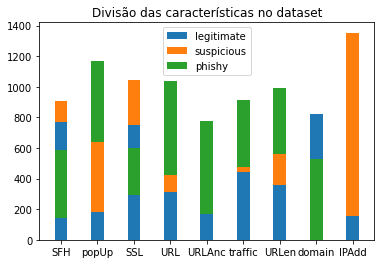

In [ ]:
# Divisão de labels em cada feature:

labels = ['SFH',	'popUp',	'SSL',	'URL',	'URLAnc',	'traffic',	'URLen',	'domain',	'IPAdd']
legitimate = [767, 182, 751, 315, 576, 440, 359, 825, 155]
suspicious = [141, 639, 294, 421, 167, 473, 563, 0, 1198]
phishy = [445, 532, 308, 617, 610, 440, 431, 528, 0]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, legitimate, width, label='legitimate')
ax.bar(labels, suspicious, width, bottom=legitimate, label='suspicious')
ax.bar(labels, phishy, width, bottom=suspicious, label='phishy')

#ax.set_ylabel('Scores')
ax.set_title('Divisão das características no dataset')
ax.legend()

plt.show()

In [ ]:
#Utilizando os classificadores

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
clf_knn = KNeighborsClassifier()
clf_rand = RandomForestClassifier()
clf_svm = SVC()

In [ ]:
X = pd.DataFrame(columns=['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor',
       'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address'], data=df)
y = np.ravel(pd.DataFrame(columns=['Result'], data=df))

In [ ]:
#Comparação de acordo com precision, recall, F-measure e acurácia

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score
scoring = {'accuracy': make_scorer(accuracy_score), 
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_macro': make_scorer(f1_score, average='weighted')}

def getMetrics(model, X, y):
  score = cross_validate(model, X, y, scoring=scoring)
  accuracy = round(score['test_accuracy'].mean(),3)
  precision = round(score['test_precision'].mean(),3)
  recall = round(score['test_recall'].mean(),3)
  f1 = round(score['test_f1_macro'].mean(),3)

  return accuracy, precision, recall, f1

In [ ]:
metrics_knn = getMetrics(clf_knn, X, y)
metrics_rand = getMetrics(clf_rand, X, y)
metrics_svm = getMetrics(clf_svm, X, y)

print('Accuracy, precision, recall e f1 p/ KNN: ', metrics_knn)
print('Accuracy, precision, recall e f1 p/ Random Forests: ', metrics_rand)
print('Accuracy, precision, recall e f1 p/ SVM: ', metrics_svm)

Accuracy, precision, recall e f1 p/ KNN:  (0.871, 0.869, 0.871, 0.869)
Accuracy, precision, recall e f1 p/ Random Forests:  (0.899, 0.899, 0.899, 0.898)
Accuracy, precision, recall e f1 p/ SVM:  (0.867, 0.859, 0.867, 0.854)


In [ ]:
# Escolhendo as características mais importantes 

forest_fit = clf_rand.fit(X, y)
importance = forest_fit.feature_importances_
importance

array([0.33391854, 0.13017534, 0.17193814, 0.09785383, 0.09078872,
       0.0561811 , 0.07907251, 0.02727378, 0.01279803])

In [ ]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(forest_fit, prefit=True)
X_novo = model.transform(X)

n_attrs = X_novo.shape[1]

idx_most_important = importance.argsort()[-n_attrs:]
print(idx_most_important)

name_important_attrs = np.array(['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor',
       'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address'])[idx_most_important]
print(name_important_attrs)

[1 2 0]
['popUpWidnow' 'SSLfinal_State' 'SFH']


In [ ]:
# Agora, recalculando as métricas: 

metrics_knn_imp = getMetrics(clf_knn, X_novo, y)
metrics_rand_imp = getMetrics(clf_rand, X_novo, y)
metrics_svm_imp = getMetrics(clf_svm, X_novo, y)

print('Accuracy, precision, recall e f1 p/ KNN (características mais relevantes): ', metrics_knn_imp)
print('Accuracy, precision, recall e f1 p/ Random Forests (características mais relevantes): ', metrics_rand_imp)
print('Accuracy, precision, recall e f1 p/ SVM (características mais relevantes): ', metrics_svm_imp)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Accuracy, precision, recall e f1 p/ KNN (características mais relevantes):  (0.825, 0.8, 0.825, 0.807)
Accuracy, precision, recall e f1 p/ Random Forests (características mais relevantes):  (0.84, 0.779, 0.84, 0.808)
Accuracy, precision, recall e f1 p/ SVM (características mais relevantes):  (0.838, 0.778, 0.838, 0.806)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Plotando gráficos de barra para comparação de cada métrica

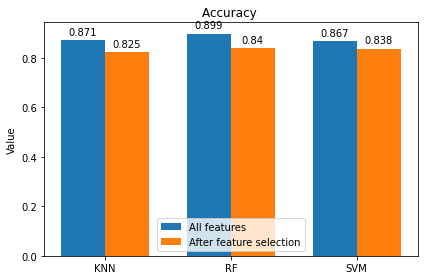

In [ ]:
# Accuracy

import matplotlib
import matplotlib.pyplot as plt

labels = ['KNN', 'RF', 'SVM']
metrics = [metrics_knn[0], metrics_rand[0], metrics_svm[0]]
metrics_importance = [metrics_knn_imp[0], metrics_rand_imp[0], metrics_svm_imp[0]]

loc = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
loc1 = [x - width/2 for x in loc]
loc2 = [x + width/2 for x in loc]

fig, ax = plt.subplots()
rects1 = ax.bar(loc1, metrics, width, label='All features')
rects2 = ax.bar(loc2, metrics_importance, width, label='After feature selection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Accuracy ')
ax.set_xticks(loc)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

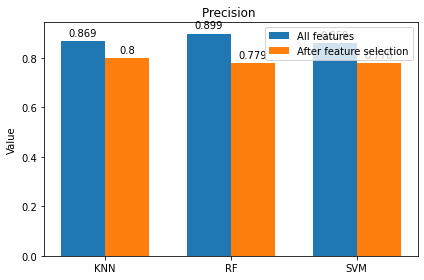

In [ ]:
# Precision

import matplotlib
import matplotlib.pyplot as plt

labels = ['KNN', 'RF', 'SVM']
metrics = [metrics_knn[1], metrics_rand[1], metrics_svm[1]]
metrics_importance = [metrics_knn_imp[1], metrics_rand_imp[1], metrics_svm_imp[1]]

loc = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
loc1 = [x - width/2 for x in loc]
loc2 = [x + width/2 for x in loc]

fig, ax = plt.subplots()
rects1 = ax.bar(loc1, metrics, width, label='All features')
rects2 = ax.bar(loc2, metrics_importance, width, label='After feature selection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Precision ')
ax.set_xticks(loc)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

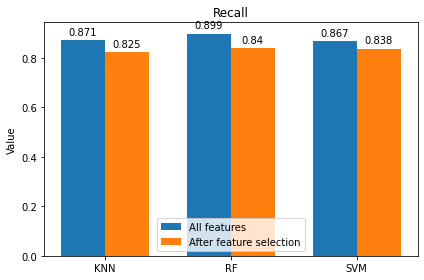

In [ ]:
# Recall

import matplotlib
import matplotlib.pyplot as plt

labels = ['KNN', 'RF', 'SVM']
metrics = [metrics_knn[2], metrics_rand[2], metrics_svm[2]]
metrics_importance = [metrics_knn_imp[2], metrics_rand_imp[2], metrics_svm_imp[2]]

loc = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
loc1 = [x - width/2 for x in loc]
loc2 = [x + width/2 for x in loc]

fig, ax = plt.subplots()
rects1 = ax.bar(loc1, metrics, width, label='All features')
rects2 = ax.bar(loc2, metrics_importance, width, label='After feature selection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Recall')
ax.set_xticks(loc)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

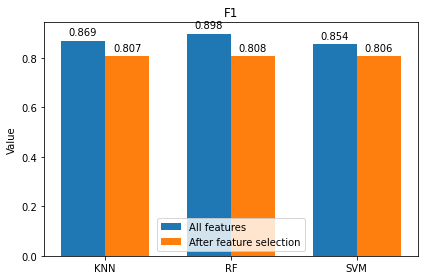

In [ ]:
# F1

import matplotlib
import matplotlib.pyplot as plt

labels = ['KNN', 'RF', 'SVM']
metrics = [metrics_knn[3], metrics_rand[3], metrics_svm[3]]
metrics_importance = [metrics_knn_imp[3], metrics_rand_imp[3], metrics_svm_imp[3]]

loc = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
loc1 = [x - width/2 for x in loc]
loc2 = [x + width/2 for x in loc]

fig, ax = plt.subplots()
rects1 = ax.bar(loc1, metrics, width, label='All features')
rects2 = ax.bar(loc2, metrics_importance, width, label='After feature selection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('F1')
ax.set_xticks(loc)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()